# Generate data for a siemens star with coded apertures

In [1]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
import cv2
import xraylib

from holotomocupy.holo import G
from holotomocupy.magnification import M
from holotomocupy.shift import S
from holotomocupy.utils import *

%matplotlib inline

np.random.seed(10)

astropy module not found
olefile module not found


In [ ]:
# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 1024  # object size in each dimension
ntheta = 1  # number of angles (rotations)

center = n/2  # rotation axis

npos = 4  # number of code positions 

detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0#np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1,[npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 8e-3  # positions of the code and the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16*0
# sample size after demagnification
ne = n+2*pad

In [ ]:
### Generate siemens star and form the transmittance function for it

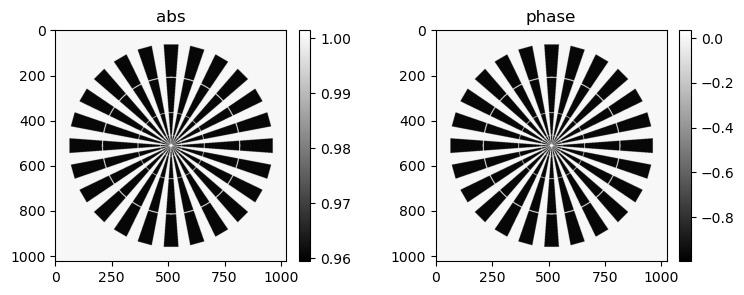

In [3]:
img = np.zeros((ne, ne, 3), np.uint8)
triangle = np.array([(ne//16, ne//2-ne//32), (ne//16, ne//2+ne//32), (ne//2-ne//128, ne//2)], np.float32)
star = img[:,:,0]*0
for i in range(0, 360, 15):
    img = np.zeros((ne, ne, 3), np.uint8)
    degree = i
    theta = degree * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], np.float32)    
    rotated = cv2.gemm(triangle-ne//2, rot_mat, 1, None, 1, flags=cv2.GEMM_2_T)+ne//2
    cv2.fillPoly(img, [np.int32(rotated)], (255, 0, 0))
    star+=img[:,:,0]
[x,y] = np.meshgrid(np.arange(-ne//2,ne//2),np.arange(-ne//2,ne//2))
x = x/ne*2
y = y/ne*2
# add holes in triangles
circ = (x**2+y**2>0.355)+(x**2+y**2<0.345)
circ *= (x**2+y**2>0.083)+(x**2+y**2<0.08)
circ *= (x**2+y**2>0.0085)+(x**2+y**2<0.008)
star = star*circ/255

v = np.arange(-ne//2,ne//2)/ne
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-5*(vx**2+vy**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(star)))
star = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 2e-6/voxelsize # siemens star thickness in pixels
# form Transmittance function
u = star*(-delta+1j*beta) # note -delta
Ru = u*thickness 
psi = np.exp(1j * Ru * voxelsize * 2 * np.pi / wavelength)[np.newaxis].astype('complex64')


mshow_polar(psi[0])

In [ ]:
## Use prb==1

In [4]:
prb = np.ones([ntheta,n+2*pad,n+2*pad],dtype='complex64')

In [ ]:
### Generate a coded aperture, make it twice bigger than the sample to allow motion

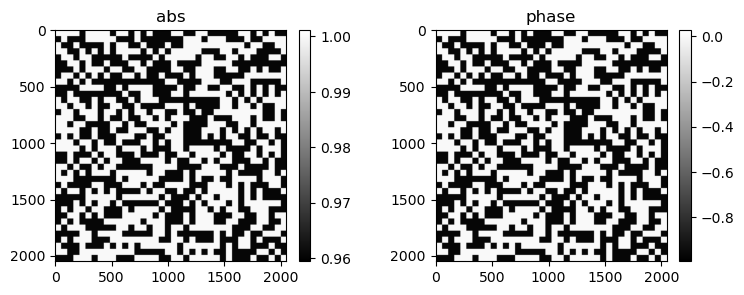

In [5]:
import random
import xraylib
import scipy.ndimage as ndimage

code_thickness = 2e-6 #in m
ill_feature_size = 1e-6 #in m

random.seed(10)
nill = 2*ne
ill_global = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = np.zeros([nill*nill],dtype='bool')
    ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)

# form codes for simulations

nill = int(ne*voxelsize/magnifications2[0]//(ill_feature_size*2))*2
ill = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
    
ill = ndimage.zoom(ill,[1,2*ne/nill,2*ne/nill],order=0,grid_mode=True,mode='grid-wrap')

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = code_thickness/voxelsize # thickness in pixels

v = np.arange(-2*ne//2,2*ne//2)/2/ne
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-3*(vx**2+vy**2))
fill = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(ill)))
ill = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fill*v)))
ill = ill.astype('complex64')


# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
code = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')

mshow_polar(code[0])

In [ ]:
### Shifts/drifts

In [6]:
# shifts of codes
shifts_code = np.round((np.random.random([ntheta, npos, 2]).astype('float32')-0.5)*ne/4)
!mkdir -p data
np.save('data/shifts_code', shifts_code)


In [ ]:
### Compute holographic projections for all angles and all distances
#### $d=\left|\mathcal{G}_{z}(\mathcal{G}_{z'}(q\mathcal{S}_{s_{j}}c)\psi)\right|_2^2$

In [7]:
from holotomocupy.chunking import gpu_batch

@gpu_batch
def fwd_holo(psi, shifts_code, prb,code):
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)    
    
    data = cp.zeros([psi.shape[0],npos,n,n],dtype='complex64')
    for i in range(npos):        
        # ill shift for each acquisition
        prbr = prb.copy()
        # code shift for each acquisition        
        coder = code.copy()
        coder = S(coder, shifts_code[:,i])    
        
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]
        
        # multiply the code and ill
        prbr *= coder        
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])
        
        psir = psi.copy()
                
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])   
        data[:,i] = psir[:,pad:n+pad,pad:n+pad]
    return data

fpsi = fwd_holo(psi,shifts_code,prb,code)

In [ ]:
### Take squared absolute value to simulate data on the detector

In [8]:
data = np.abs(fpsi)**2

In [ ]:
### Visualize data

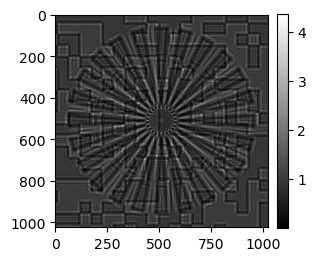

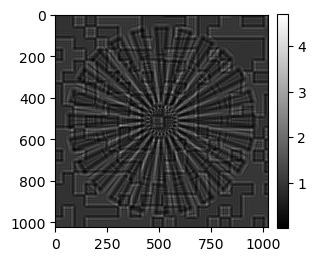

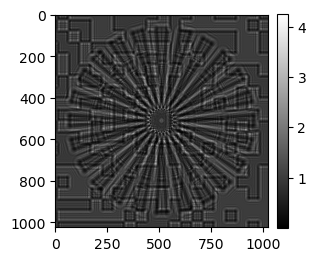

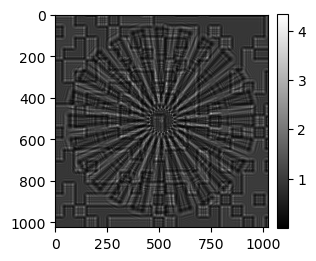

In [9]:
for k in range(npos):
    mshow(data[0,k])

In [ ]:
### Save data and shifts

In [10]:
for k in range(len(distances)):
    write_tiff(data[:,k],f'data/data_{n}_{k}')
np.save('data/code',code)